# HUMAN

## CMD

In [1]:
!git clone https://github.com/DevTimlas/pifuhd.git

Cloning into 'pifuhd'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 236 (delta 98), reused 92 (delta 85), pack-reused 97 (from 1)
Receiving objects: 100% (236/236), 515.59 KiB | 712.00 KiB/s, done.
Resolving deltas: 100% (120/120), done.


In [4]:
import os
if not os.path.exists('lightweight-human-pose-estimation.pytorch/checkpoint_iter_370000.pth'):
    !git clone https://github.com/Daniil-Osokin/lightweight-human-pose-estimation.pytorch.git
    %cd lightweight-human-pose-estimation.pytorch/
    !wget https://download.01.org/opencv/openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth

Cloning into 'lightweight-human-pose-estimation.pytorch'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 124 (delta 21), reused 19 (delta 18), pack-reused 90 (from 1)
Receiving objects: 100% (124/124), 230.77 KiB | 340.00 KiB/s, done.
Resolving deltas: 100% (53/53), done.
/Users/mac/fivv/2D-3D/latest/lightweight-human-pose-estimation.pytorch
--2024-08-23 10:40:45--  https://download.01.org/opencv/openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth
Resolving download.01.org (download.01.org)... 

/opt/anaconda3/envs/torch/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


23.63.89.29
Connecting to download.01.org (download.01.org)|23.63.89.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87959810 (84M) [application/octet-stream]
Saving to: ‘checkpoint_iter_370000.pth’

checkpoint_iter_370 100%[===================>]  83.88M  2.74MB/s    in 26s     

2024-08-23 10:41:12 (3.18 MB/s) - ‘checkpoint_iter_370000.pth’ saved [87959810/87959810]



In [12]:
!pwd

/Users/mac/fivv/2D-3D/latest/lightweight-human-pose-estimation.pytorch


In [13]:
%cd ..

/Users/mac/fivv/2D-3D/latest


In [14]:
#@title # Download the Pretrained Model
if not os.path.exists("pifuhd/checkpoints/pifuhd.pt"):
    %cd pifuhd
    !bash ./scripts/download_trained_model.sh
else:
    print("Model already exists")

/Users/mac/fivv/2D-3D/latest/pifuhd
+ mkdir -p checkpoints
+ cd checkpoints
+ wget https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt pifuhd.pt
--2024-08-23 10:43:45--  https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.78.80, 108.157.78.39, 108.157.78.29, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.78.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1548375177 (1.4G) [application/octet-stream]
Saving to: ‘pifuhd.pt’

pifuhd.pt           100%[===================>]   1.44G  1.99MB/s    in 8m 8s   

2024-08-23 10:51:55 (3.02 MB/s) - ‘pifuhd.pt’ saved [1548375177/1548375177]

--2024-08-23 10:51:55--  http://pifuhd.pt/
Resolving pifuhd.pt (pifuhd.pt)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘pifuhd.pt’
FINISHED --2024-08-23 10:51:55--
Total wall clock time: 8m 10s
Downloaded: 1 files, 1.4G in 8m

In [17]:
!pwd

/Users/mac/fivv/2D-3D/latest/pifuhd


In [18]:
%cd ..

/Users/mac/fivv/2D-3D/latest


/opt/anaconda3/envs/torch/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [28]:
import os

os.makedirs('/Users/mac/fivv/2D-3D/latest/sample_images/', exist_ok=True)

In [29]:
image_path = '/Users/mac/fivv/2D-3D/latest/sample_images/e37e33c07644a547690fd225133201aa.jpg'

In [30]:
%cd /Users/mac/fivv/2D-3D/latest/lightweight-human-pose-estimation.pytorch
import torch
import cv2
import numpy as np
from models.with_mobilenet import PoseEstimationWithMobileNet
from modules.keypoints import extract_keypoints, group_keypoints
from modules.load_state import load_state
from modules.pose import Pose, track_poses
import demo

def get_rect(net, images, height_size):
    net = net.eval()

    stride = 8
    upsample_ratio = 4
    num_keypoints = Pose.num_kpts
    previous_poses = []
    delay = 33
    for image in images:
        rect_path = image.replace('.%s' % (image.split('.')[-1]), '_rect.txt')
        img = cv2.imread(image, cv2.IMREAD_COLOR)
        orig_img = img.copy()
        orig_img = img.copy()
        heatmaps, pafs, scale, pad = demo.infer_fast(net, img, height_size, stride, upsample_ratio, cpu=True)

        total_keypoints_num = 0
        all_keypoints_by_type = []
        for kpt_idx in range(num_keypoints):  # 19th for bg
            total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

        pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs)
        for kpt_id in range(all_keypoints.shape[0]):
            all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
            all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
        current_poses = []

        rects = []
        for n in range(len(pose_entries)):
            if len(pose_entries[n]) == 0:
                continue
            pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
            valid_keypoints = []
            for kpt_id in range(num_keypoints):
                if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
                    pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
                    pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
                    valid_keypoints.append([pose_keypoints[kpt_id, 0], pose_keypoints[kpt_id, 1]])
            valid_keypoints = np.array(valid_keypoints)

            if pose_entries[n][10] != -1.0 or pose_entries[n][13] != -1.0:
              pmin = valid_keypoints.min(0)
              pmax = valid_keypoints.max(0)

              center = (0.5 * (pmax[:2] + pmin[:2])).astype(np.int32)
              radius = int(0.65 * max(pmax[0]-pmin[0], pmax[1]-pmin[1]))
            elif pose_entries[n][10] == -1.0 and pose_entries[n][13] == -1.0 and pose_entries[n][8] != -1.0 and pose_entries[n][11] != -1.0:
              # if leg is missing, use pelvis to get cropping
              center = (0.5 * (pose_keypoints[8] + pose_keypoints[11])).astype(np.int32)
              radius = int(1.45*np.sqrt(((center[None,:] - valid_keypoints)**2).sum(1)).max(0))
              center[1] += int(0.05*radius)
            else:
              center = np.array([img.shape[1]//2,img.shape[0]//2])
              radius = max(img.shape[1]//2,img.shape[0]//2)

            x1 = center[0] - radius
            y1 = center[1] - radius

            rects.append([x1, y1, 2*radius, 2*radius])

        np.savetxt(rect_path, np.array(rects), fmt='%d')


net = PoseEstimationWithMobileNet()
checkpoint = torch.load('checkpoint_iter_370000.pth', map_location='cpu')
load_state(net, checkpoint)

get_rect(net, [image_path], 512)

/opt/anaconda3/envs/torch/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/mac/fivv/2D-3D/latest/lightweight-human-pose-estimation.pytorch


In [31]:
image_dir = os.path.dirname(image_path)
image_dir

'/Users/mac/fivv/2D-3D/latest/sample_images'

In [33]:
%cd /Users/mac/fivv/2D-3D/latest/pifuhd/
!python -m apps.simple_test -r 256 --use_rect -i {image_dir}

/Users/mac/fivv/2D-3D/latest/pifuhd
Resuming from  ./checkpoints/pifuhd.pt
test data size:  1
initialize network with normal
initialize network with normal
generate mesh (test) ...
100%|█████████████████████████████████████████████| 1/1 [00:37<00:00, 37.99s/it]


## API

In [1]:
import requests

# Specify the image file and the API endpoint
file_path = "/Users/mac/fivv/2D-3D/latest/sample_images/e37e33c07644a547690fd225133201aa.jpg"
url = "http://127.0.0.1:6000/generate-mesh"

# Open the file in binary mode
with open(file_path, "rb") as file:
    # Send the POST request with the file
    response = requests.post(url, files={"file": file})

# Save the response content as an .obj file
if response.status_code == 200:
    out = "out2.obj"
    with open(out, "wb") as f:
        f.write(response.content)
    print(f"OBJ file saved as {out}.")
else:
    print("Error:", response.status_code)


OBJ file saved as out2.obj.


# GARMENT

In [5]:
!pip -q install trimesh
!pip -q install ninja
!pip -q install rembg
!pip install -q open3d

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with 

In [28]:
!pip install -U numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 2.0 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 4.1 MB/s eta 0:00:0000:0100:01
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.42.0
    Uninstalling llvmlite-0.42.0:
      Successfully uninstalled llvmlite-0.42.0
  Attempting uninstall: numba
    Found existing installation: numba 0.59.0rc1
    Uninstalling numba-0.59.0rc1:
      Successfully uninstalled numba-0.59.0rc1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

In [15]:
!pip install --upgrade gdown

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [1]:
import os
%cd /Users/mac/fivv/2D-3D/latest
if not os.path.exists('AnchorUDF'):
    !git clone https://github.com/zhaofang0627/AnchorUDF.git
    %cd AnchorUDF
    !git clone https://github.com/ThibaultGROUEIX/ChamferDistancePytorch.git
else:
    print('Anchor repo exists')

%cd /Users/mac/fivv/2D-3D/latest

/Users/mac/fivv/2D-3D/latest
Anchor repo exists
/Users/mac/fivv/2D-3D/latest


/opt/anaconda3/envs/torch/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
!pwd

/Users/mac/fivv/2D-3D/latest


In [3]:
import gdown

# a file
if not os.path.exists('netG_epoch_59'):
    url = "https://drive.google.com/uc?id=1lByZSWTUZ2T3sFSoMoUK8nu72kiV3C96"
    url2 = "https://drive.google.com/uc?id=1z2Y1OnpaoN9jlSyA7XQEQ056mMHlaQPq"
    # output = "netG_epoch_59"
    gdown.download(url)
    gdown.download(url2)
else:
    print('netG_epoch_59 present')

netG_epoch_59 present


In [4]:
filename = 'BALLY_MTR031_CO315_U901_01.webp'

In [13]:
#@title RM IMG BG

import os
if os.path.exists(f'{os.getcwd()}/AnchorUDF/pics/my_test'):
    os.remove(f'{os.getcwd()}/AnchorUDF/pics/my_test')

os.makedirs(f"{os.getcwd()}/AnchorUDF/pics/my_test/MASK/1", exist_ok=True)
os.makedirs(f"{os.getcwd()}/AnchorUDF/pics/my_test/RENDER/1", exist_ok=True)

from rembg import remove
from PIL import Image

# Store path of the image in the variable input_path
input_path = f'{os.getcwd()}/sample_images/{filename}'
print(input_path)

# Store path of the output image in the variable output_path
output_path = f'{os.getcwd()}/AnchorUDF/pics/my_test/RENDER/1/0_0_00.jpg'

# Processing the image
input_image = Image.open(input_path)
print('input image size', input_image.size)

# Determine the new size based on the original image size

if input_image.size[0] <= 600 or input_image.size[1] <= 600:
    new_size = (500, 500)
elif input_image.size[0] >= 900 or input_image.size[1] >= 900:
    new_size = (1500, 1500)
elif input_image.size[0] <= 900 or input_image.size[1] <= 900 and input_image.size[0] >= 700 or input_image.size[1] >= 700:
    new_size = (1000, 1000)
else:
    new_size = input_image.size

# Resize the image
resized_image = input_image.resize(new_size, Image.LANCZOS)
print('resized image size', resized_image.size)

# Removing the background from the given Image
output_image = remove(resized_image)

# Convert the output image to RGB format
rgb_output_image = output_image.convert('RGB')

# Save the image in the given path
rgb_output_image.save(output_path, quality=200, optimize=True)
print(f'Output image saved to {output_path}')

/Users/mac/fivv/2D-3D/latest/sample_images/BALLY_MTR031_CO315_U901_01.webp
input image size (2000, 2500)
resized image size (1500, 1500)
Output image saved to /Users/mac/fivv/2D-3D/latest/AnchorUDF/pics/my_test/RENDER/1/0_0_00.jpg


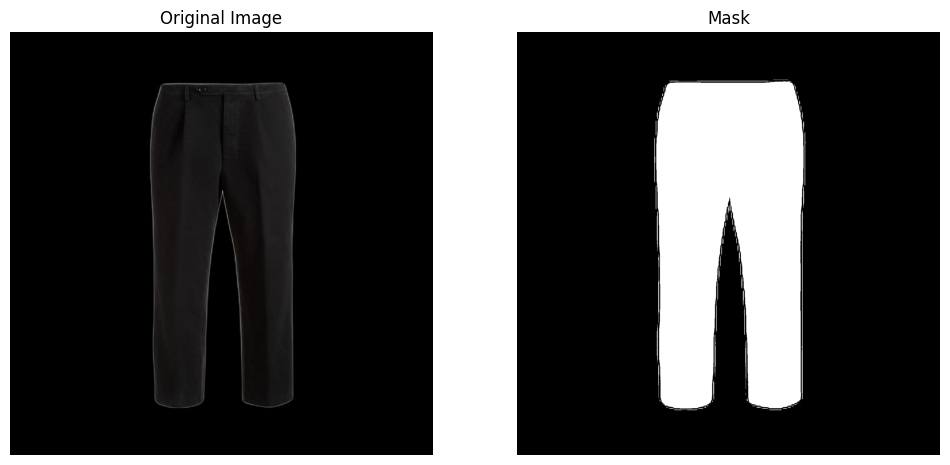

Image resized to (1500, 1500, 3)


In [14]:
#@title GET INPUT MASK
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image_path = f"{os.getcwd()}/AnchorUDF/pics/my_test/RENDER/1/0_0_00.jpg"
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a binary threshold to get a binary image
_, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask with the same dimensions as the image
mask = np.zeros_like(gray)

# Fill the mask with the contours
cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)

# Plot the original image and the mask
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.show()

# Save the mask to a file
mask_path = f"{os.getcwd()}/AnchorUDF/pics/my_test/MASK/1/0_0_00.png"
cv2.imwrite(mask_path, mask)

print(f"Image resized to {image.shape}")

In [16]:
pwd

'/Users/mac/fivv/2D-3D/latest'

In [28]:
#@title Garment inference

path_of_output = "out"
folder_of_output = "out"
path_of_dataset = f'{os.getcwd()}/pics/my_test'
folder_of_test_data = "1"
ckpt = os.path.join('/Users/mac/fivv/2D-3D/latest', 'netG_epoch_59')

%cd /Users/mac/fivv/2D-3D/latest/AnchorUDF
!rm -rf /Users/mac/fivv/2D-3D/latest/AnchorUDF/out
!python -m apps.eval --results_path {path_of_output} --name {folder_of_output}\
                     --dataroot {path_of_dataset} --test_folder_path {folder_of_test_data}\
                     --load_netG_checkpoint_path {ckpt} --anchor --num_steps 2\
                     --filter_val 0.0075 --max_dist 0.05 --num_gen_points 850000 --gamma 1 \
                     --aug_bri 1.5 --aug_con 0.5 --aug_sat 0.5 --aug_hue 0.5

/Users/mac/fivv/2D-3D/latest/AnchorUDF
cpu
initialize network with normal
Using Network:  AnchorUDFNet
/Users/mac/fivv/2D-3D/latest/AnchorUDF/pics/my_test/RENDER/1/0_0_00.jpg /Users/mac/fivv/2D-3D/latest/AnchorUDF/pics/my_test/MASK/1/0_0_00.png
iteration 0
refinement 0
tensor([[0.4962, 0.1015, 0.1897,  ..., 0.6960, 0.5805, 0.7860]],
       grad_fn=<SqueezeBackward1>)
refinement 1
tensor([[0.4962, 0.1015, 0.1897,  ..., 0.6960, 0.5805, 0.7860]],
       grad_fn=<SqueezeBackward1>)
finished refinement
(0, 3)
iteration 1
refinement 0
tensor([[0.0065, 0.0044, 0.0128,  ..., 0.0050, 0.0045, 0.0141]],
       grad_fn=<SqueezeBackward1>)
refinement 1
tensor([[0.0062, 0.0043, 0.0058,  ..., 0.0041, 0.0045, 0.0059]],
       grad_fn=<SqueezeBackward1>)
finished refinement
(193974, 3)
iteration 2
refinement 0
tensor([[0.0068, 0.0050, 0.0042,  ..., 0.0047, 0.0104, 0.0238]],
       grad_fn=<SqueezeBackward1>)
refinement 1
tensor([[0.0052, 0.0043, 0.0042,  ..., 0.0047, 0.0060, 0.0030]],
       grad_fn=<S